In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms  # image specific torch functions bc we will work with the MNIST dataset
from torchvision.utils import make_grid
from torch import nn
from torchsummary import summary
import torch.optim as optim



In [2]:
dataset = "cifar"

In [3]:
# Hyperparameters

if dataset == "mnist":
    z_dim = 100             # Dimension of noise vector
    batch_size = 128        # Batch size
    lr = 0.0002             # Learning rate
    beta1 = 0.5             # Adam optimizer beta1
    epochs = 50             # Number of training epochs


if dataset == "cifar":
    z_dim = 100             # Dimension of noise vector
    batch_size = 128        # Batch size
    lr = 0.0002             # Learning rate
    beta1 = 0.5             # Adam optimizer beta1
    epochs = 100            # Number of training epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# Deep Convolutional GAN (DCGAN)

############ MINST dataset ##################
# Use z_dimension of 64, 100, or 128, not higher!

# Generator definition DCGAN
class GeneratorMINST(nn.Module):
    def __init__(self, z_dim):
        super(GeneratorMINST, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        if z.dim() == 2:
            z = z.unsqueeze(-1).unsqueeze(-1)  # Reshape to (B, z_dim, 1, 1)
        return self.gen(z)

class DiscriminatorMNIST(nn.Module):
    def __init__(self):
        super(DiscriminatorMNIST, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 7x7 -> 4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),  # Flatten (256 * 4 * 4)
            nn.Linear(256 * 4 * 4, 1),  # Fully connected layer for binary classification
            nn.Sigmoid()  # Output probability
        )

    def forward(self, x):
        return self.disc(x)

############ CIFAR dataset ##################

# Use z_dimension of 128

class GeneratorCIFAR(nn.Module): # DCGAN
    def __init__(self, z_dim):
        super(GeneratorCIFAR, self).__init__()
        self.gen = nn.Sequential(
            # Project and reshape
            nn.Linear(z_dim, 256 * 4 * 4),  # Map z to (256, 4, 4)
            nn.BatchNorm1d(256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),  # Reshape to (256, 4, 4)
            
            # Upsampling blocks
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # 16x16 -> 32x32
            nn.Tanh()  # Normalize to [-1, 1]
        )

    def forward(self, z):
        return self.gen(z)

class DiscriminatorCIFAR(nn.Module):
    def __init__(self):
        super(DiscriminatorCIFAR, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),  # 4x4 -> 1x1
            nn.Sigmoid()  # Output scalar probability
        )

    def forward(self, x):
        return self.disc(x).view(-1)  # Flatten output to (B,)


In [5]:
# Parameters
if dataset == "mnist":
    
    print("MNIST Generator")
    generator = GeneratorMINST(z_dim).to(device)
    # Generate noise and pass it to the generator
    z = torch.randn(batch_size, z_dim, device=device)  # Generate noise on the correct device
    output = generator(z)  # Forward pass
    
    print(f"Output shape: {output.shape}")  # Should be (B, 1, 28, 28)
    
    # Summary
    summary(generator, input_size=(z_dim, 1, 1), device=str(device)) # input size without batch
    
    print("       ")
    
    print("MNIST Discriminant")
    
    discriminator = DiscriminatorMNIST().to(device)
    
    print(f"Output shape: {discriminator(output).shape}")  # Should be (B, 1, 28, 28)
    
    # Summary
    summary(discriminator, input_size=(output.shape[1:]), device=str(device)) # input size without batch
    
if dataset == "cifar":

    print("CIFAR Generator")
    generator = GeneratorCIFAR(z_dim).to(device)
    # Generate noise and pass it to the generator
    z = torch.randn(batch_size, z_dim, device=device)  # Generate noise on the correct device
    output = generator(z)  # Forward pass
    
    print(f"Output shape: {output.shape}")  # Should be (B, 1, 32, 32)
    
    # Summary
    summary(generator, input_size=(z_dim,), device=str(device)) # input size without batch
    
    print("       ")
    
    print("CIFAR Discriminant")
    
    discriminator = DiscriminatorCIFAR().to(device)
    
    print(f"Output shape: {discriminator(output).shape}")  # Should be (B, 1, 28, 28)
    
    # Summary
    summary(discriminator, input_size=(output.shape[1:]), device=str(device)) # input size without batch

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

initialize_weights(generator)
initialize_weights(discriminator)

CIFAR Generator
Output shape: torch.Size([128, 3, 32, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         413,696
       BatchNorm1d-2                 [-1, 4096]           8,192
              ReLU-3                 [-1, 4096]               0
         Unflatten-4            [-1, 256, 4, 4]               0
   ConvTranspose2d-5            [-1, 128, 8, 8]         524,416
       BatchNorm2d-6            [-1, 128, 8, 8]             256
              ReLU-7            [-1, 128, 8, 8]               0
   ConvTranspose2d-8           [-1, 64, 16, 16]         131,136
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]           3,075
             Tanh-12            [-1, 3, 32, 32]               0
Total params: 1,080,899
Trainable params: 1,

In [6]:
print("Getting the datset for ", dataset)


if dataset == "cifar":
    # CIFAR dataset (32x32 and 10 classes)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  
    train_data = datasets.CIFAR10(root='CIFAR', train=True, download=True, transform=transform)

if dataset == "mnist":
    # MNNIST (28 x 28)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_data = datasets.MNIST(root='MNIST', train=True, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
print("Total # of batches in train set ", len(train_loader))


Getting the datset for  cifar
Files already downloaded and verified
Total # of batches in train set  391


real images in  cifar


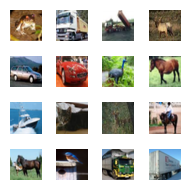

In [7]:
print("real images in ", dataset)
real_images = [train_data[i][0] for i in range(0, 16)]
#real_images = real_images.cpu().numpy()

if dataset == "mnist":
    fig, ax = plt.subplots(4, 4, figsize=(5, 5))
    for i, img in enumerate(real_images):
        ax[i // 4, i % 4].imshow(img.squeeze(), cmap='gray')
        ax[i // 4, i % 4].axis('off')
    plt.show()

else:

    real_images = [train_data[i][0] for i in range(16)]

    
    # Denormalization function
    def denormalize(img):
        mean = [0.5, 0.5, 0.5]  # Means used in normalization
        std = [0.5, 0.5, 0.5]   # Standard deviations used in normalization
        img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
        return img

    fig, ax = plt.subplots(4, 4, figsize= (2, 2))
    for i in range(16):
        img = real_images[i]  # Get image and label
        img = denormalize(img)  # Remove normalization
        img = img.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].axis('off')
    plt.tight_layout()
    plt.show()



In [10]:
# Binary Cross-Entropy Loss
criterion = nn.BCELoss()

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


for epoch in range(epochs):
    
    d_loss_epoch = 0.0  # Accumulate discriminator loss for the epoch
    g_loss_epoch = 0.0  # Accumulate generator loss for the epoch
    total_batches = len(train_loader)

    for batch_idx, (real_images, _) in enumerate(train_loader):
        # Move real images to the device
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create labels
        if dataset == "mnist":
            real_labels = torch.ones(batch_size, 1, device=device)  # Real = 1
            fake_labels = torch.zeros(batch_size, 1, device=device) # Fake = 0
        else:
            real_labels = torch.ones(batch_size, device=device)  # Real = 1
            fake_labels = torch.zeros(batch_size, device=device) # Fake = 0
            

        ## Train Discriminator ##
        d_optimizer.zero_grad()
        
        # Discriminator loss on real images
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)
        
        # Generate fake images
        noise = torch.randn(batch_size, z_dim, device=device)  # Noise vector
        fake_images = generator(noise)
        
        # Discriminator loss on fake images
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        
        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        ## Train Generator ##
        g_optimizer.zero_grad()
        
        # Generate fake images
        noise = torch.randn(batch_size, z_dim, device=device)  # Noise vector
        fake_images = generator(noise)
        
        # Generator loss (try to trick discriminator)
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)  # Flip labels for generator
        
        g_loss.backward()
        g_optimizer.step()

        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

    # Calculate average losses for the epoch
    d_loss_avg = d_loss_epoch / total_batches
    g_loss_avg = g_loss_epoch / total_batches

    # Print summary for the epoch
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"D Loss: {d_loss_avg:.4f}, G Loss: {g_loss_avg:.4f}")


Epoch [1/100] D Loss: 0.4287, G Loss: 4.3509
Epoch [2/100] D Loss: 0.6598, G Loss: 3.3717
Epoch [3/100] D Loss: 0.7488, G Loss: 2.4537
Epoch [4/100] D Loss: 0.6146, G Loss: 2.7158
Epoch [5/100] D Loss: 0.6924, G Loss: 2.3042
Epoch [6/100] D Loss: 0.7765, G Loss: 2.1236
Epoch [7/100] D Loss: 0.7729, G Loss: 1.9410
Epoch [8/100] D Loss: 0.7881, G Loss: 1.9965
Epoch [9/100] D Loss: 0.7713, G Loss: 1.9999
Epoch [10/100] D Loss: 0.7417, G Loss: 1.9887
Epoch [11/100] D Loss: 0.7139, G Loss: 2.0209
Epoch [12/100] D Loss: 0.7757, G Loss: 2.0338
Epoch [13/100] D Loss: 0.7929, G Loss: 1.9325
Epoch [14/100] D Loss: 0.7767, G Loss: 1.8975
Epoch [15/100] D Loss: 0.7479, G Loss: 1.9361
Epoch [16/100] D Loss: 0.7543, G Loss: 1.9418
Epoch [17/100] D Loss: 0.7474, G Loss: 1.8913
Epoch [18/100] D Loss: 0.7779, G Loss: 1.8955
Epoch [19/100] D Loss: 0.7647, G Loss: 1.8930
Epoch [20/100] D Loss: 0.7501, G Loss: 1.9181
Epoch [21/100] D Loss: 0.7566, G Loss: 1.8803
Epoch [22/100] D Loss: 0.7429, G Loss: 1.90

Fake images


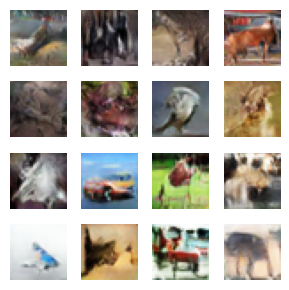

Real images


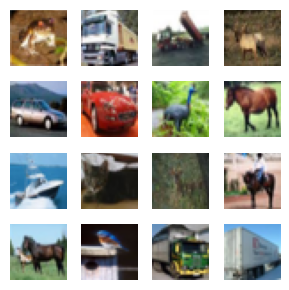

In [37]:
import matplotlib.pyplot as plt

if dataset == "mnist":
    # Generate and visualize fake images
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(16, z_dim, device=device) # generate 16 noise samples
        fake_images = generator(noise)
        fake_images = fake_images.cpu().numpy()
    
    # Plot images
    print("Fake images")
    fig, ax = plt.subplots(4, 4, figsize=(2, 2))
    for i, img in enumerate(fake_images):
        ax[i // 4, i % 4].imshow(img.squeeze(), cmap='gray')
        ax[i // 4, i % 4].axis('off')
    plt.show()
        
    print("real images")
    real_images = [train_data[i][0] for i in range(0, 16)]
    #real_images = real_images.cpu().numpy()
    
    fig, ax = plt.subplots(4, 4, figsize=(2, 2))
    for i, img in enumerate(real_images):
        ax[i // 4, i % 4].imshow(img.squeeze(), cmap='gray')
        ax[i // 4, i % 4].axis('off')
    plt.show()

if dataset == "cifar":

    # Generate and visualize fake images
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(16, z_dim, device=device)  # Generate 16 noise samples
        fake_images = generator(noise).detach().cpu()  # Move to CPU for plotting
    
    # Plot fake images
    print("Fake images")
    fig, ax = plt.subplots(4, 4, figsize=(3, 3))  # Larger figure size
    for i in range(16):
        img = fake_images[i]
        img = img * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
        img = img.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
        ax[i // 4, i % 4].imshow(img.clip(0, 1))  # Clip to [0, 1] for valid pixel values
        ax[i // 4, i % 4].axis('off')
    plt.tight_layout()
    plt.show()
    
    # Plot real images
    print("Real images")
    real_images = [train_data[i][0] for i in range(16)]  # Get 16 real images
    fig, ax = plt.subplots(4, 4, figsize=(3, 3))  # Larger figure size
    for i in range(16):
        img = real_images[i]
        img = denormalize(img)  # Remove normalization
        img = img.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
        ax[i // 4, i % 4].imshow(img.clip(0, 1))  # Clip to [0, 1] for valid pixel values
        ax[i // 4, i % 4].axis('off')
    plt.tight_layout()
    plt.show()


In [38]:
torch.save(generator.state_dict(), 'generator_'+dataset+'.pth')
torch.save(discriminator.state_dict(), 'discriminator_'+dataset+'.pth')